<a href="https://colab.research.google.com/github/erzar0/engineering-thesis/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

# npz = np.load('/content/drive/MyDrive/thesis/Gasecki/Gasecki_data_corr_total.npz', allow_pickle=True)
# gasecki_e_xy = npz["E_xy"]

npz = np.load('/content/drive/MyDrive/thesis/Sobieski/Sobieski_data_corr_total.npz', allow_pickle=True)
sobieski_e_xy = npz["E_xy"]

# npz = np.load('/content/drive/MyDrive/thesis/Matka_Boska/Matka_Boska_data_corr_total_Cu.npz', allow_pickle=True)
# matka_boska_e_xy = npz["E_xy"]

npz = np.load('/content/drive/MyDrive/thesis/Blank_PcbCu/GEM_Cr_PBS1_Blank_PcbCu_ArCO2_75_25_Gain_35_Thr_35_HV_3640_Xray_50kV_04mA_part_001_GainCorr.pcap.dat.npz', allow_pickle=True)
copper_plate_e_xy = npz["E_xy"]

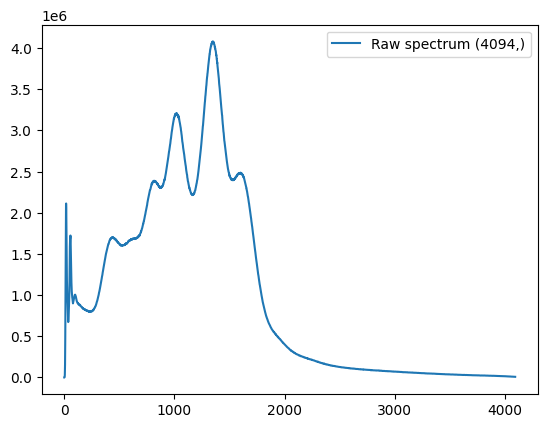

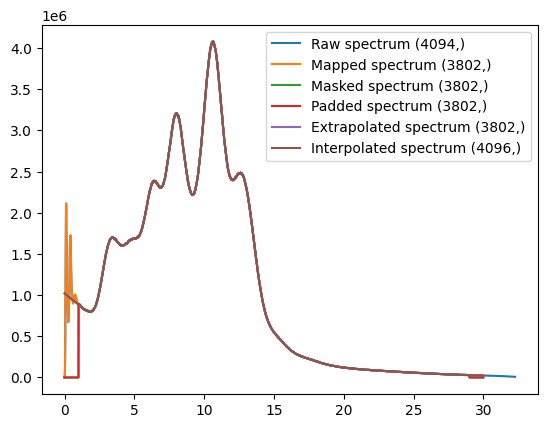

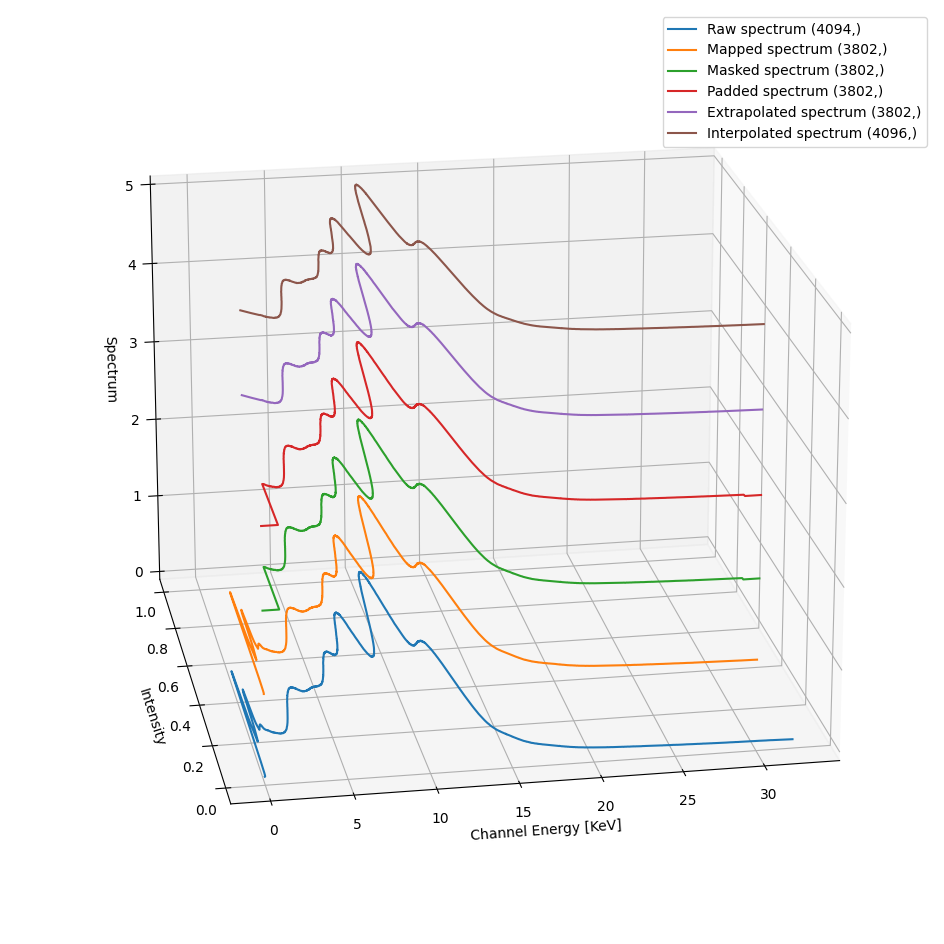

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def preprocess_energy(e_xy, peaks, energies, min_energy=0, max_energy=30
               , energy_margin=1, target_length=4096, points_to_extrapolate_count=100
               , plot=False):
    # Calculate channel to energy mapping
    correction_coefficients = np.polyfit(peaks, energies, 1)
    channel_energies = np.poly1d(correction_coefficients)(np.arange(e_xy.shape[-1]))

    spectrum_acc = np.sum(e_xy, (0,1), dtype=np.uint32)

    # Fit spectrum in range [min_energy, max_energy]
    mask = (channel_energies >= min_energy) & (channel_energies <= max_energy)
    channel_energies_mapped = channel_energies[mask]
    spectrum_acc_mapped = spectrum_acc[mask]

    # Mask edges of spectrum by energy_margin, as they have lots of noise
    energy_margin = (channel_energies_mapped < (channel_energies_mapped[0] + energy_margin)) | (channel_energies_mapped > channel_energies_mapped[-1] - energy_margin)
    spectrum_acc_masked = spectrum_acc_mapped.copy()
    spectrum_acc_masked[energy_margin] = 0

    # Padd spectrum to the right to make sure that it fills entire energy range [min_energy, max_energy]
    step_size = channel_energies_mapped[1] - channel_energies_mapped[0]
    step_count = int((max_energy - channel_energies_mapped[-1]) // step_size)
    channel_energies_extrapolated = np.concatenate((channel_energies_mapped, np.linspace(channel_energies_mapped[-1], max_energy, step_count)))
    spectrum_acc_padded = np.concatenate((spectrum_acc_masked, np.zeros(step_count)))

    # Extrapolate masked start of spectrum
    def exponential_function(x, a, b):
        return a * np.exp(b * x)

    spectrum_acc_extrapolated = spectrum_acc_padded.copy()
    non_zero_start_idx = np.where((spectrum_acc_padded == 0) & (np.arange(len(spectrum_acc_padded)) < 1000))[0][-1] + 1
    params, covariance = curve_fit(exponential_function
                                   , channel_energies_extrapolated[non_zero_start_idx:non_zero_start_idx + points_to_extrapolate_count]
                                   , spectrum_acc_padded[non_zero_start_idx:non_zero_start_idx + points_to_extrapolate_count]
                                   , maxfev=2000)
    y_extrapolate = exponential_function(channel_energies_extrapolated[:non_zero_start_idx], *params)
    spectrum_acc_extrapolated[:non_zero_start_idx] = y_extrapolate

    # Extrapolate masked end of spectrum
    non_zero_end_idx = np.where((spectrum_acc_padded == 0) & (np.arange(len(spectrum_acc_padded)) > 1000))[0][0]
    params, covariance = curve_fit(exponential_function
                                   , channel_energies_extrapolated[non_zero_end_idx - points_to_extrapolate_count:non_zero_end_idx]
                                   , spectrum_acc_padded[non_zero_end_idx - points_to_extrapolate_count:non_zero_end_idx]
                                   , maxfev=2000)
    y_extrapolate = exponential_function(channel_energies_extrapolated[non_zero_end_idx:], *params)
    spectrum_acc_extrapolated[non_zero_end_idx:] = y_extrapolate

    # Interpolate to achieve target_length, so it could be processed by neural network
    min_energy = channel_energies_extrapolated[0]
    max_energy = channel_energies_extrapolated[-1]
    channel_energies_interpolated = interp1d(channel_energies_extrapolated, channel_energies_extrapolated, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))
    spectrum_acc_interpolated = interp1d(channel_energies_extrapolated, spectrum_acc_extrapolated, fill_value="extrapolate")(np.linspace(min_energy, max_energy, target_length))


    if plot:
        plt.figure(1)
        plt.plot(spectrum_acc, label=f"Raw spectrum {spectrum_acc.shape}")
        plt.legend()

        # Plotting 2D plot
        plt.figure(2)
        plt.plot(channel_energies, spectrum_acc, label=f"Raw spectrum {spectrum_acc.shape}")
        plt.plot(channel_energies_mapped, spectrum_acc_mapped, label=f"Mapped spectrum {spectrum_acc_mapped.shape}")
        plt.plot(channel_energies_mapped, spectrum_acc_masked, label=f"Masked spectrum {spectrum_acc_masked.shape}")
        plt.plot(channel_energies_extrapolated, spectrum_acc_padded, label=f"Padded spectrum {spectrum_acc_padded.shape}")
        plt.plot(channel_energies_extrapolated, spectrum_acc_extrapolated, label=f"Extrapolated spectrum {spectrum_acc_extrapolated.shape}")
        plt.plot(channel_energies_interpolated, spectrum_acc_interpolated, label=f"Interpolated spectrum {spectrum_acc_interpolated.shape}")
        plt.legend()

        # Plotting the 3D series of 2D plots
        fig = plt.figure(3, figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(channel_energies, spectrum_acc / np.max(spectrum_acc), zs=0, label=f"Raw spectrum {spectrum_acc.shape}")
        ax.plot(channel_energies_mapped, spectrum_acc_mapped / np.max(spectrum_acc_mapped), zs=1, label=f"Mapped spectrum {spectrum_acc_mapped.shape}")
        ax.plot(channel_energies_mapped, spectrum_acc_masked / np.max(spectrum_acc_masked), zs=2, label=f"Masked spectrum {spectrum_acc_masked.shape}")
        ax.plot(channel_energies_extrapolated, spectrum_acc_padded / np.max(spectrum_acc_padded), zs=3, label=f"Padded spectrum {spectrum_acc_padded.shape}")
        ax.plot(channel_energies_extrapolated, spectrum_acc_extrapolated / np.max(spectrum_acc_extrapolated), zs=4, label=f"Extrapolated spectrum {spectrum_acc_extrapolated.shape}")
        ax.plot(channel_energies_interpolated, spectrum_acc_interpolated / np.max(spectrum_acc_interpolated), zs=5, label=f"Interpolated spectrum {spectrum_acc_interpolated.shape}")
        ax.set_xlabel('Channel Energy [KeV]')
        ax.set_ylabel('Intensity')
        ax.set_zlabel('Spectrum')
        ax.view_init(elev=20, azim=260)
        ax.legend()
        plt.show()

    return channel_energies_interpolated, spectrum_acc_interpolated

peaks_sobieski = [817, 1016,1347, 1598]
energies_sobieski = [6.405, 8.046, 10.551, 12.614]
channel_energies_mapped, spectrum_acc_mapped = preprocess_energy(sobieski_e_xy, peaks_sobieski, energies_sobieski, plot=True)

# peaks_copper_plate = [720, 985, 1594, 2068]
# energies_copper_plate = [3.692, 5.088, 8.046, 10.551]

# channel_energies, spectrum_acc = map_energy(copper_plate_e_xy, peaks_copper_plate, energies_copper_plate)



"Copper plate" mean photon count: 424.95355224609375
"Copper plate" standard deviation of photon count: 143.14790594655412


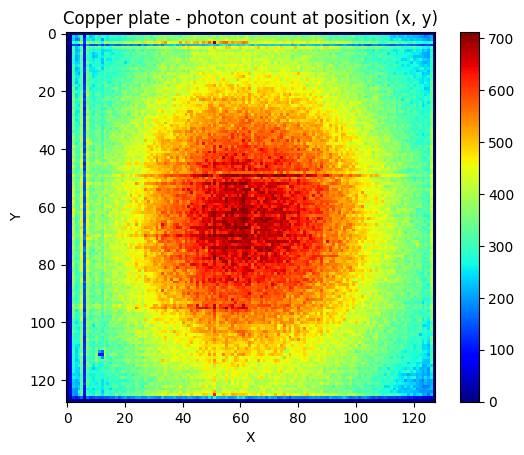

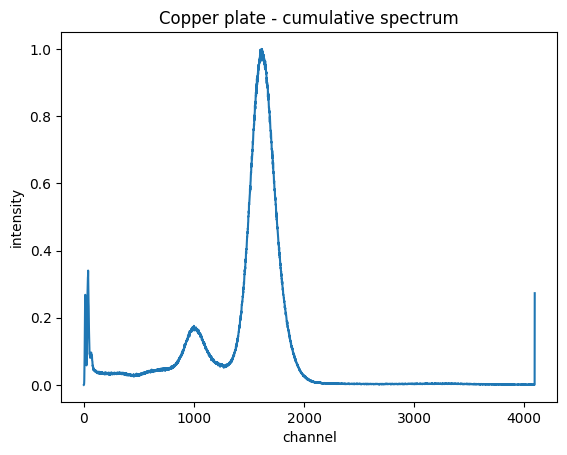

In [ ]:
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

def show_stats(measurement, name=None):
    measurement_photon_count = np.sum(measurement, axis=-1)

    mu = np.mean(measurement_photon_count)
    sigma = np.var(measurement_photon_count)**0.5
    print(f"\"{name}\" mean photon count: {mu}")
    print(f"\"{name}\" standard deviation of photon count: {sigma}")

    plt.figure(random.randint(1, 10e10))
    plt.imshow(measurement_photon_count, cmap='jet', interpolation='nearest', vmax=mu + 2 * sigma)
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{name} - photon count at position (x, y)")
    plt.show()

    cumulative_spectrum = np.sum(measurement, (0, 1))
    cumulative_spectrum = cumulative_spectrum / np.max(cumulative_spectrum)
    plt.figure(random.randint(1, 10e10))
    plt.xlabel("channel")
    plt.ylabel("intensity")
    plt.title(f"{name} - cumulative spectrum")
    plt.plot(cumulative_spectrum)

show_stats(copper_plate_e_xy, name="Copper plate")
# show_stats(gasecki_e_xy, name="Gąsecki")
# show_stats(sobieski_e_xy, name="Sobieski")
# show_stats(matka_boska_e_xy, name="Matka Boska")

0.960477642600464 11.891788830989356 0.6016726366135688
0.624873866653596


8.503354916285307

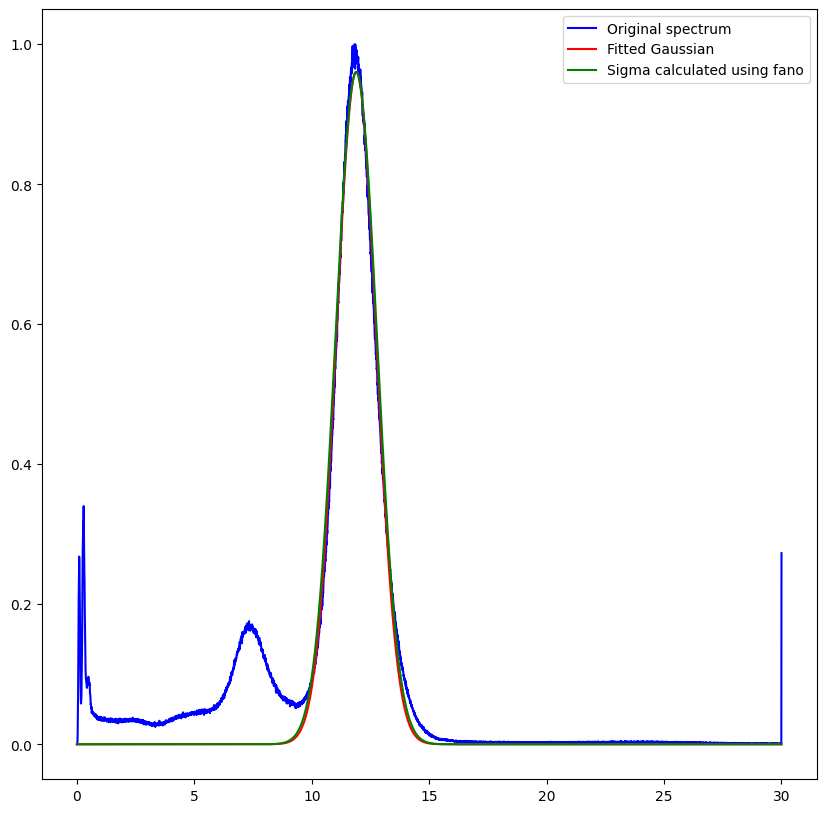

In [ ]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

def calculate_fano_factor(fwhm, average_energy):
    fano_factor = (2.354**2 * fwhm**2) / average_energy
    return fano_factor

def calculate_fano(spectrum):
    x_values = np.linspace(0, 30, len(spectrum))
    (amplitude_opt, mean_opt, stddev_opt), _ = curve_fit(gaussian, x_values, spectrum)

    fitted_curve = gaussian(x_values, amplitude_opt, mean_opt, stddev_opt)

    fwhm = 2.354 * stddev_opt
    fano = ( fwhm**2 ) / (mean_opt * 2.354**2 * 0.00358 )
    sigma_calculated_with_fano = np.sqrt((0.08/2.354)**2 + 0.00385 * fano * mean_opt)

    plt.figure(figsize=(10, 10))
    plt.plot(x_values, spectrum, label='Original spectrum', color='blue')
    plt.plot(x_values, fitted_curve, label='Fitted Gaussian', color='red')
    plt.plot(x_values, gaussian(x_values, amplitude_opt, mean_opt, sigma_calculated_with_fano), label="Sigma calculated using fano", color="green")
    print(amplitude_opt, mean_opt, stddev_opt)
    print(sigma_calculated_with_fano)

    plt.legend()

    return fano


cumulative_spectrum = np.sum(copper_plate_e_xy, (0, 1))
cumulative_spectrum = cumulative_spectrum / np.max(cumulative_spectrum)
calculate_fano(cumulative_spectrum)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

class SelfOrganizingMap:
    def __init__(self, input_size, map_size, learning_rate=0.1, sigma=1.0):
        self.input_size = input_size
        self.map_size = map_size
        self.learning_rate = learning_rate
        self.sigma = sigma

        self.weights = np.random.rand(map_size[0], map_size[1], input_size)

    def calculate_distance(self, input_vector, weights):
        return np.linalg.norm(input_vector - weights, )

    def find_best_matching_unit(self, input_vector):
        distances = np.zeros((self.map_size[0], self.map_size[1]))
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                distances[i, j] = self.calculate_distance(input_vector, self.weights[i, j])
        bmu_coords = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_coords

    def update_weights(self, input_vector, bmu_coords, iteration):
        decay_factor = np.exp(-iteration / self.sigma)
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                influence = np.exp(-((i - bmu_coords[0])**2 + (j - bmu_coords[1])**2) / (2 * (self.sigma**2)))
                update = self.learning_rate * decay_factor * influence * (input_vector - self.weights[i, j])
                self.weights[i, j] += update

    def train(self, data, epochs):
        for epoch in tqdm(range(epochs)):
            for input_vector in data:
                bmu_coords = self.find_best_matching_unit(input_vector)
                self.update_weights(input_vector, bmu_coords, epoch)

In [ ]:
def get_som_clustered_labels(e_xy, epochs=10, map_size=(3,3), learning_rate=0.1, sigma=0.5):
    e_xy_flat= e_xy.reshape(-1, e_xy.shape[-1])
    e_xy_max_channel_counts = np.max(np.abs(e_xy_flat), axis=1, keepdims=True)
    e_xy_flat_normalized = e_xy_flat/ e_xy_max_channel_counts
    som = SelfOrganizingMap(input_size=e_xy.shape[-1], map_size=map_size, learning_rate=learning_rate, sigma=sigma)
    som.train(e_xy_flat_normalized, epochs)
    bmus = [[som.find_best_matching_unit(e_xy_flat_normalized[i * e_xy.shape[1] + j]) for j in range(e_xy.shape[1])] for i in range(e_xy.shape[0])]
    labels = [[bmu[0] * map_size[1] + bmu[1] for bmu in bmus_row] for bmus_row in bmus]
    return labels



In [ ]:
e_xy = sobieski_e_xy[-150:, -150:, 100:-100]

100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


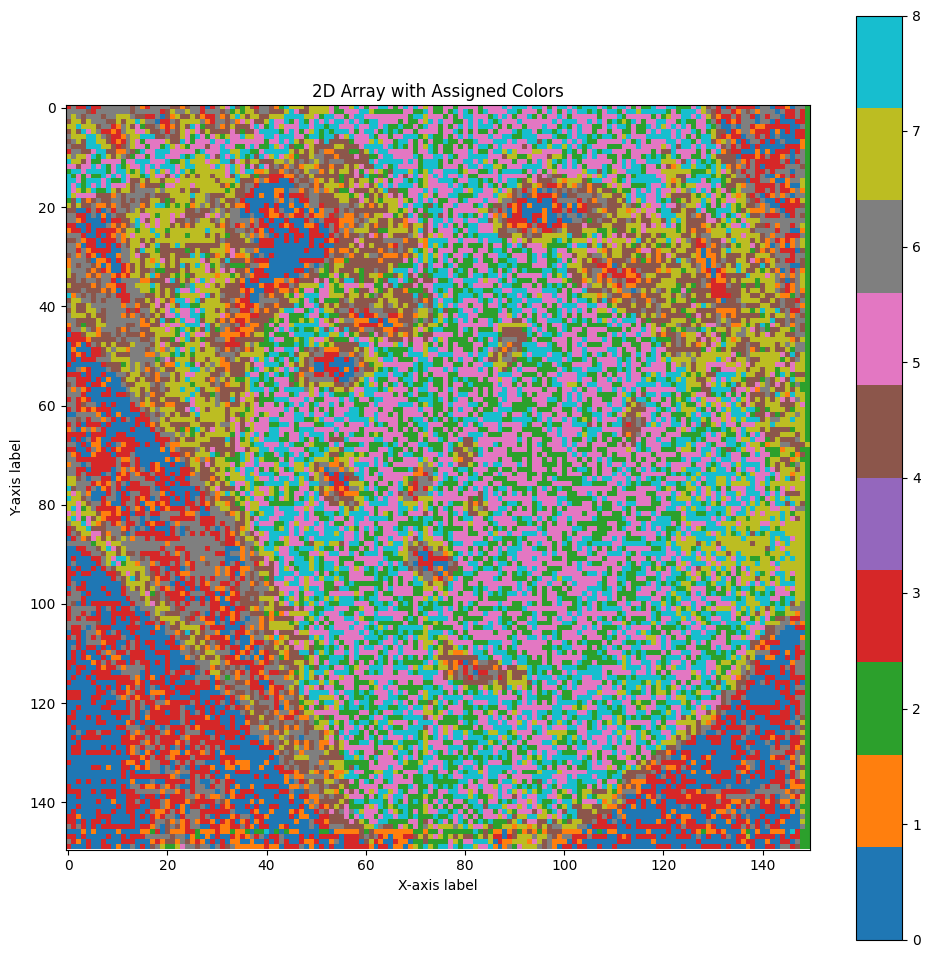

In [ ]:
labels = get_som_clustered_labels(e_xy)

plt.figure(figsize=(12,12))
plt.imshow(labels, cmap="tab10", interpolation='nearest')

plt.colorbar()
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('2D Array with Assigned Colors')

plt.show()

In [ ]:
def get_measurement_mask(measurement, labels, label):
    mask = np.zeros(measurement.shape[:-1], dtype=bool)
    mask [np.array(labels).reshape(measurement.shape[:-1]) == label] = True
    return mask

In [ ]:
def get_label_masks(e_xy, labels, plot=True):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    grid_size = int(np.ceil(np.sqrt(num_labels)))
    label_masks = {}
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            label = i * grid_size + j
            if label < num_labels:
                label_mask = get_measurement_mask(e_xy, labels, unique_labels[label])
                label_masks[label] = label_mask
                ax[i][j].imshow(label_mask, cmap='viridis')
                ax[i][j].set_title(f'Label {unique_labels[i * grid_size + j]}')
                ax[i][j].axis('off')
    return label_masks


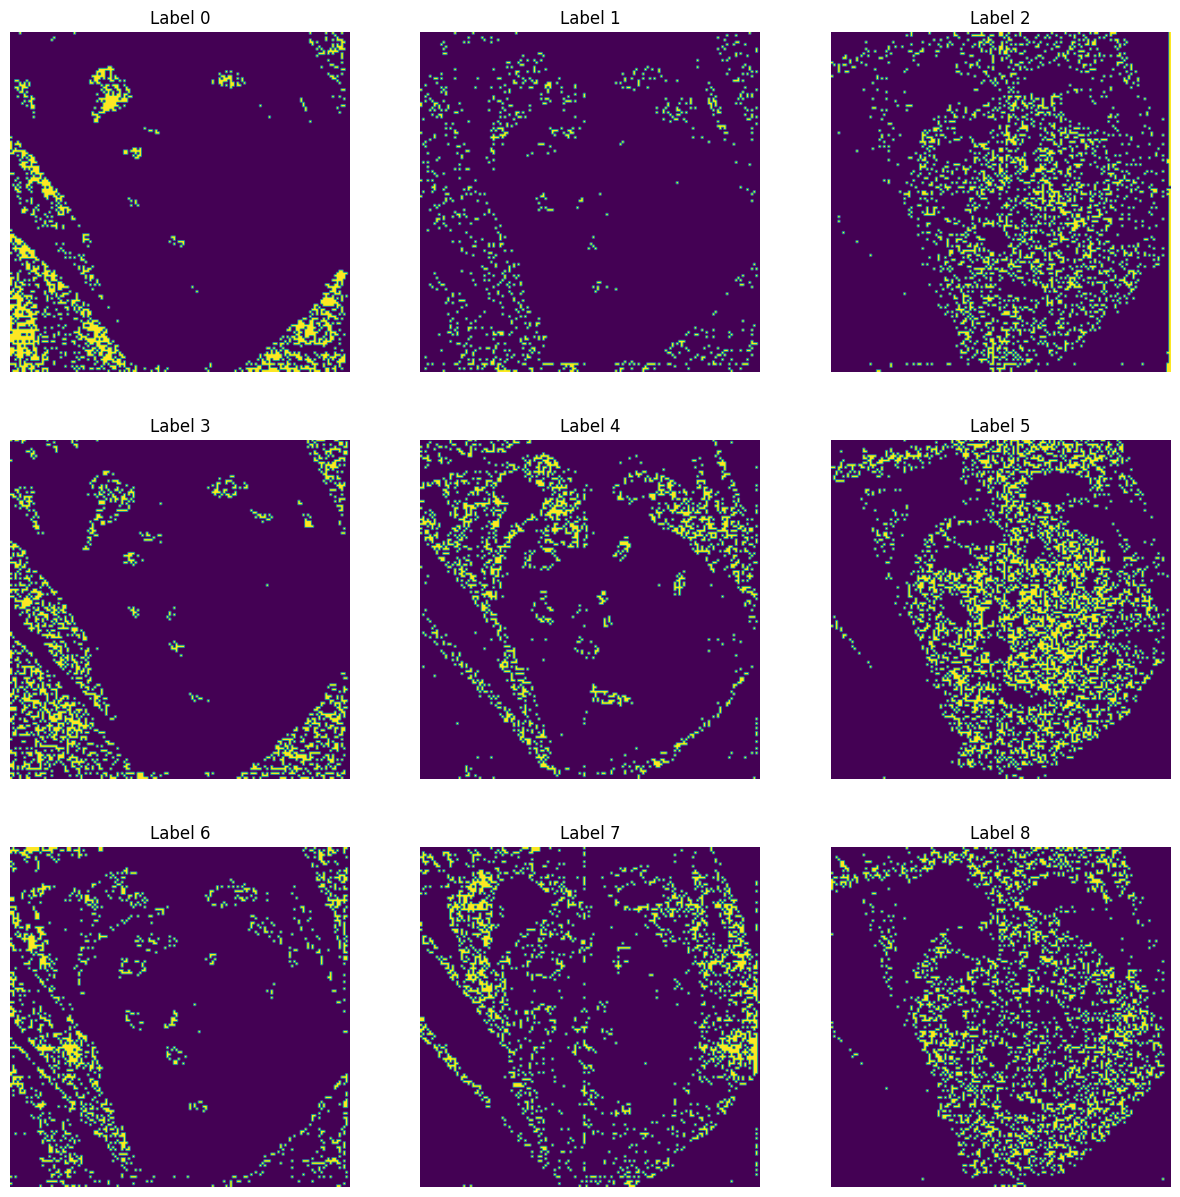

In [ ]:
label_masks = get_label_masks(e_xy, labels)

In [ ]:
peaks_sobieski = [817, 1016,1347, 1598]
energies_sobieski = [6.405, 8.046, 10.551, 12.614]
def plot_clustered_spectra(e_xy, label_masks, labels, peaks, energies):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    grid_size = int(np.ceil(np.sqrt(num_labels)))
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            label = i * grid_size + j
            if label in label_masks.keys():
                mask = label_masks[label]
                energy = e_xy * mask[:, :, np.newaxis]
                channel_energies, spectrum_acc = preprocess_energy(energy, peaks, energies_sobieski)
                ax[i][j].plot(channel_energies, spectrum_acc / np.max(spectrum_acc), label=f"Cluster {label}")
                ax[i][j].set_xlabel("Channel")
                ax[i][j].set_ylabel("Normalized Intensity")
                ax[i][j].set_title(f'Label {label}')



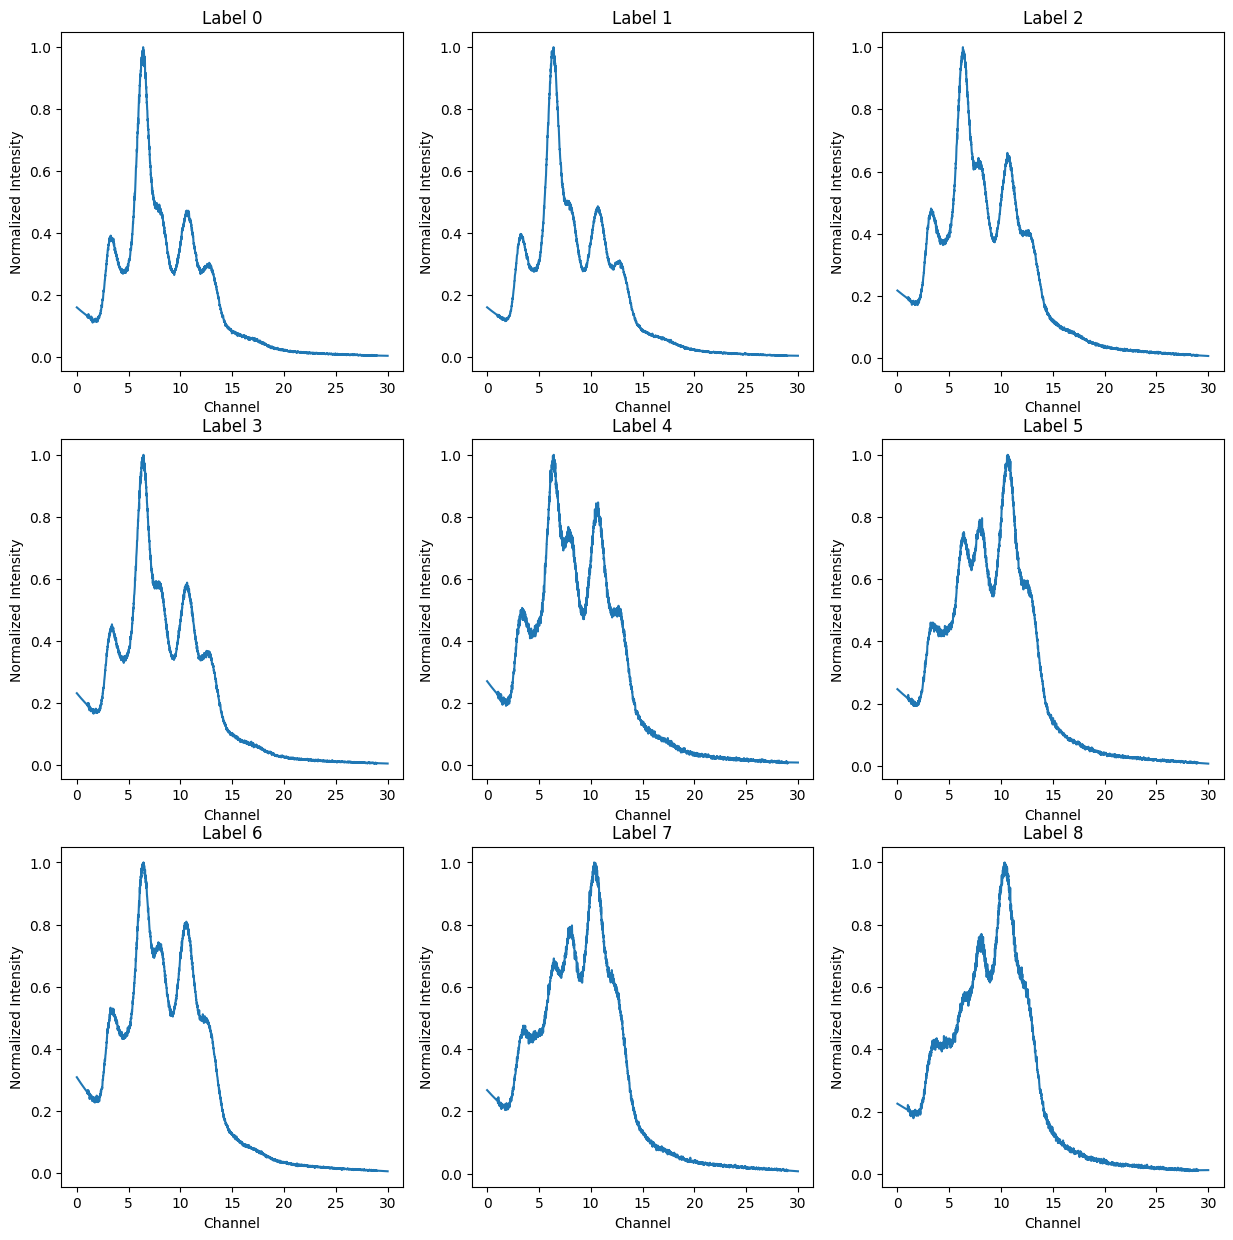

In [ ]:
plot_clustered_spectra(e_xy, label_masks, labels, peaks_sobieski, energies_sobieski)

In [ ]:
!pip install hdbscan
!pip install umap-learn


In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.collect()

e_xy_flat= e_xy.reshape(-1, e_xy.shape[-1])
e_xy_max_channel_counts = np.max(np.abs(e_xy_flat), axis=1, keepdims=True)
e_xy_flat_normalized = e_xy_flat/ e_xy_max_channel_counts

clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
).fit_transform(e_xy_flat_normalized)

In [ ]:
import hdbscan

clusterable_embedding = clusterable_embedding.reshape(e_xy_flat.shape[0], 2)
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
    metric='l1'
).fit_predict(clusterable_embedding)

[-1  0  1  2  3]


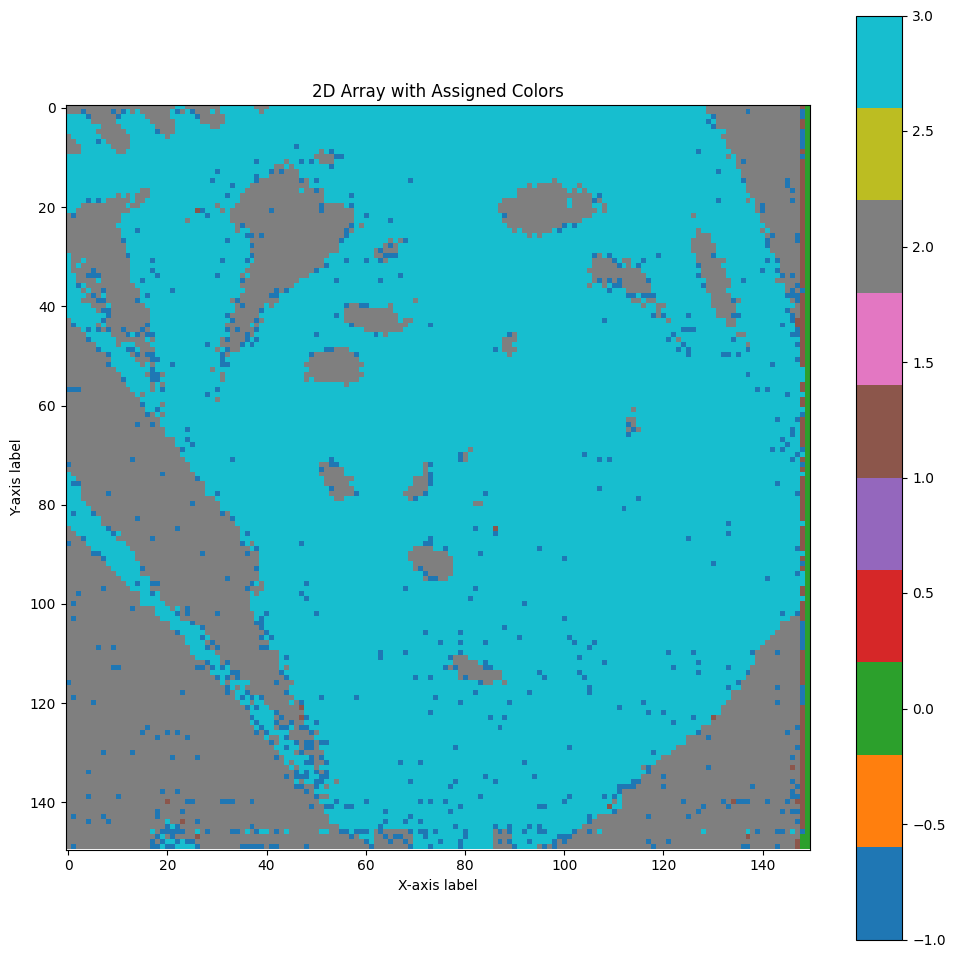

In [ ]:
plt.figure(figsize=(12,12))

plt.imshow(labels.reshape(*e_xy.shape[:-1]), cmap="tab10", interpolation="nearest")

plt.colorbar()
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('2D Array with Assigned Colors')
print(np.unique(labels))
plt.show()

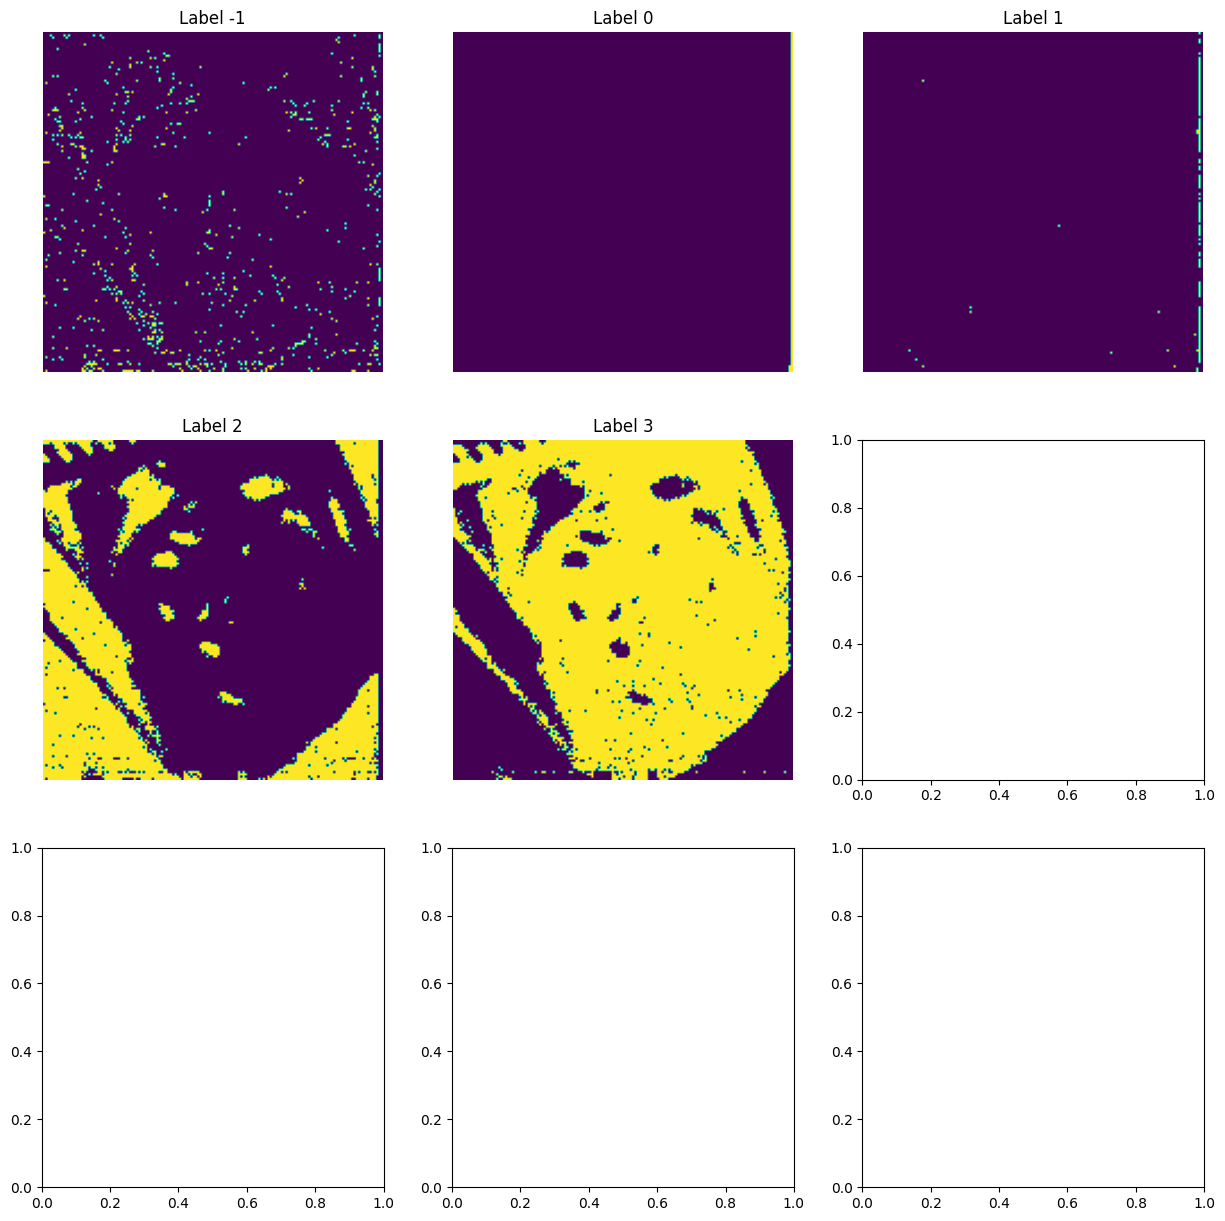

In [ ]:
label_masks = get_label_masks(e_xy, labels)

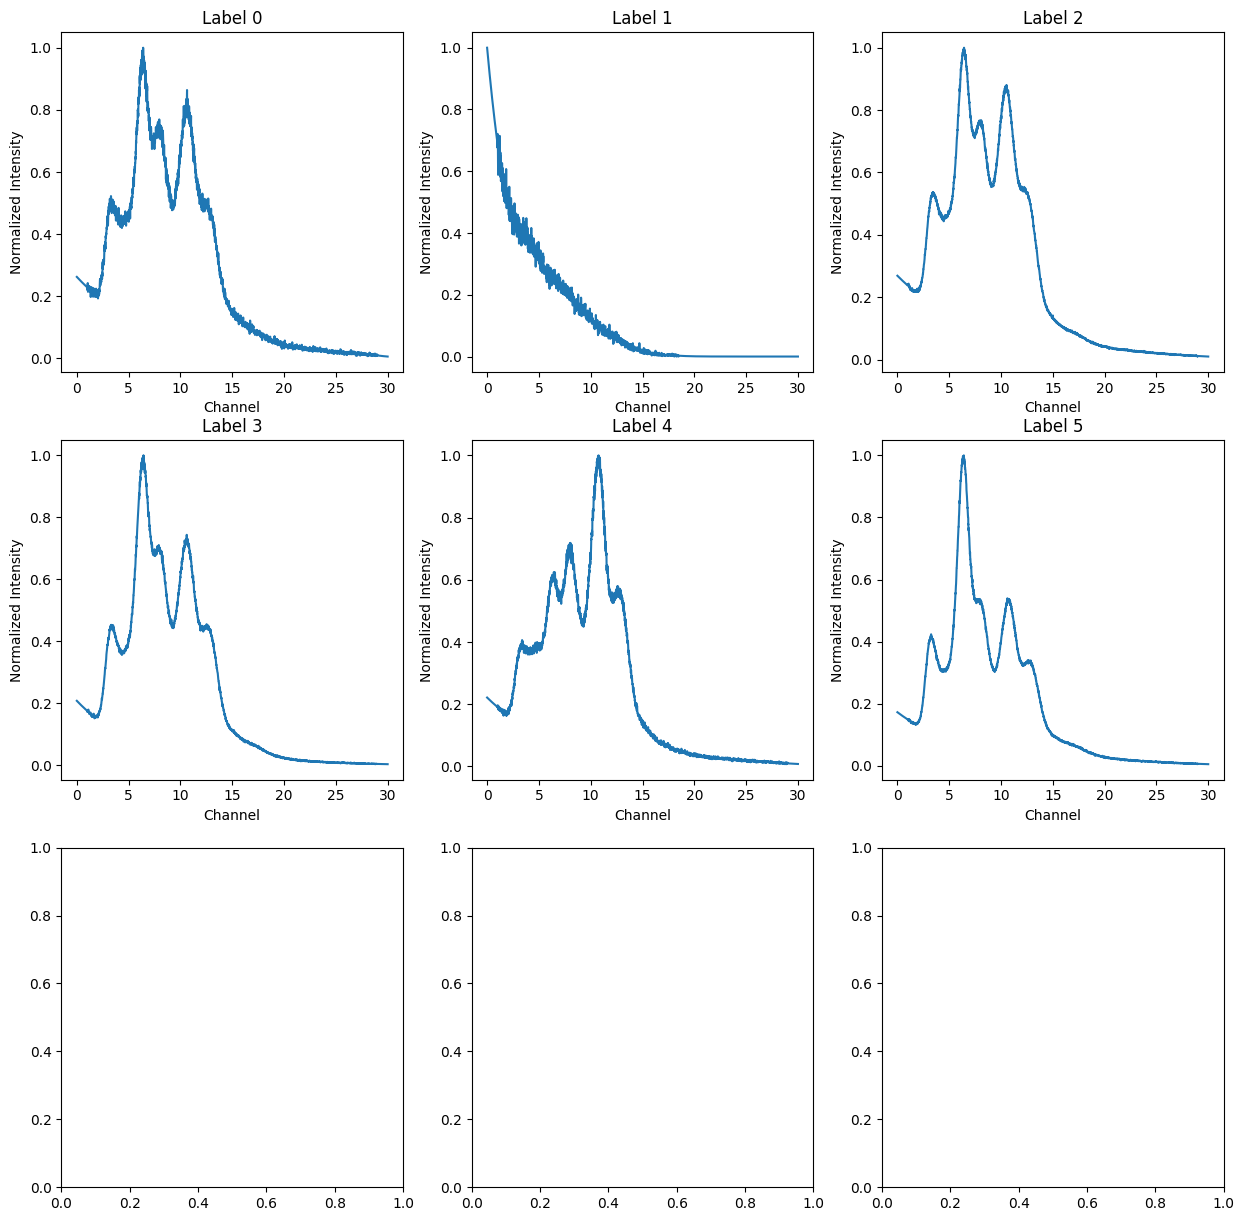

In [ ]:
plot_clustered_spectra(e_xy, label_masks, labels, peaks_sobieski, energies_sobieski)